# Analyzing borrowers’ risk of defaulting

**The task is to prepare a report for a bank’s loan division.** We’ll need to find out if a customer’s marital status and number of children has an impact on whether they will default on a loan. The bank already has some data on customers’ credit worthiness.

The **credit score** is used to evaluate the ability of a potential borrower to repay their loan.

We've got the following questions to be answered:
1. Is there a connection between having kids and repaying a loan on time?
1. Is there a connection between marital status and repaying a loan on time?
1. Is there a connection between income level and repaying a loan on time?
1. How do different loan purposes affect on-time loan repayment?

Let's investigate the data, keeping in mind our goals.

## Open the data file and have a look at the general information.

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sidetable
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemma = WordNetLemmatizer()

# Printing more than 1 output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# Loading the data (making possible working through different connections)
try:
    data = pd.read_csv(r'C:\Users\4from\Desktop\Practicum\2 Data preprocessing\credit_scoring_eng.csv')
except:
    data = pd.read_csv('/datasets/credit_scoring_eng.csv')

## Task 1. Data exploration

**Description of the data**
- `children` - the number of children in the family
- `days_employed` - work experience in days
- `dob_years` - client's age in years
- `education` - client's education
- `education_id` - education identifier
- `family_status` - marital status
- `family_status_id` - marital status identifier
- `gender` - gender of the client
- `income_type` - type of employment
- `debt` - was there any debt on loan repayment
- `total_income` - monthly income
- `purpose` - the purpose of obtaining a loan

[Now let's explore our data. You'll want to see how many columns and rows it has, look at a few rows to check for potential issues with the data.]

In [3]:
# Let's see how many rows and columns our dataset has
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


- **2 out of 11 columns have obvious missing values: 'days_employed' and 'total_income'**
- data types are OK (relevant to the data characteristics). Meanwhile, it would be better to transform floats into integers. We can do it later on after getting rid of missing values (that can cause errors when proceeding with transformation).

In [4]:
# Let's see the main descriptive statistics of data
data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,19351.000000
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,26787.568355
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,16475.450632
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,3306.762000
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,16488.504500
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,23202.870000
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,32549.611000
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,362496.645000


Here we see the following issues:
- **negative values in the 'children' column**
- **doubtfully high maximum number of children** (taking in account relatively low number of mean and upper quartile)
- **negative values in the 'days_employed' column**
- **enormous numbers in the 'days_employed' column** (days employed worth of several human lives)

In [5]:
# let's print the first rows
data.head(20)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding
5,0,-926.185831,27,bachelor's degree,0,civil partnership,1,M,business,0,40922.170,purchase of the house
6,0,-2879.202052,43,bachelor's degree,0,married,0,F,business,0,38484.156,housing transactions
7,0,-152.779569,50,SECONDARY EDUCATION,1,married,0,M,employee,0,21731.829,education
8,2,-6929.865299,35,BACHELOR'S DEGREE,0,civil partnership,1,F,employee,0,15337.093,having a wedding
9,0,-2188.756445,41,secondary education,1,married,0,M,employee,0,23108.150,purchase of the house for my family


- Here we see **duplicates in 'education' column** (statuses with the same meaning but written both with uppercase and lowercase letters)

In [6]:
# Checking the number of missing values and calculate the percentage of them compared to the whole dataset
print('Missing values:')
for i in data:    
    if data[i].isna().sum()>0:
        print(i,'-', data[i].isna().sum()) # checking the number of missing values        
        print(i,'-', round(data[i].isna().sum()/len(data)*100), '%') # hecking the % of missing values

Missing values:
days_employed - 2174
days_employed - 10 %
total_income - 2174
total_income - 10 %


What we can see here:
- (as we mentioned above) only two columns have obvious **missing values: 'days_employed' and 'total_income' columns**.
- as the numbers of these missing values in two columns are equal, there is **a (high) chance that these cases are interconnected**, further investigations are needed as well.

In [7]:
# Let's look in the filtered table with missing data in the 'days_employed' column 
data[data['days_employed'].isna()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,secondary education,1,civil partnership,1,M,retiree,0,NaN,to have a wedding
26,0,NaN,41,secondary education,1,married,0,M,civil servant,0,NaN,education
29,0,NaN,63,secondary education,1,unmarried,4,F,retiree,0,NaN,building a real estate
41,0,NaN,50,secondary education,1,married,0,F,civil servant,0,NaN,second-hand car purchase
55,0,NaN,54,secondary education,1,civil partnership,1,F,retiree,1,NaN,to have a wedding
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Secondary Education,1,married,0,M,business,0,NaN,purchase of a car
21495,1,NaN,50,secondary education,1,civil partnership,1,F,employee,0,NaN,wedding ceremony
21497,0,NaN,48,BACHELOR'S DEGREE,0,married,0,F,business,0,NaN,building a property
21502,1,NaN,42,secondary education,1,married,0,F,employee,0,NaN,building a real estate


Here we see that **missing values in days_employed and total_income colmns seem to be in the same rows / cases all the time**. We can easily check this, to be sure in our assumption.

In [8]:
# Let's apply multiple conditions for filtering data and look at the number of rows in the filtered table.
data[(data['days_employed'].isna()) & (data['total_income'].isna())]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,secondary education,1,civil partnership,1,M,retiree,0,NaN,to have a wedding
26,0,NaN,41,secondary education,1,married,0,M,civil servant,0,NaN,education
29,0,NaN,63,secondary education,1,unmarried,4,F,retiree,0,NaN,building a real estate
41,0,NaN,50,secondary education,1,married,0,F,civil servant,0,NaN,second-hand car purchase
55,0,NaN,54,secondary education,1,civil partnership,1,F,retiree,1,NaN,to have a wedding
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Secondary Education,1,married,0,M,business,0,NaN,purchase of a car
21495,1,NaN,50,secondary education,1,civil partnership,1,F,employee,0,NaN,wedding ceremony
21497,0,NaN,48,BACHELOR'S DEGREE,0,married,0,F,business,0,NaN,building a property
21502,1,NaN,42,secondary education,1,married,0,F,employee,0,NaN,building a real estate


 **Intermediate conclusion**

**The number of rows in the subset of the data above** (where the values are missing in both columns at the same time) **is the same as in our previous dataset** (where just one of those columns contains missing values only). So, 2174 rows = 2174 rows.
Thus **we can conclude that these missing values are not random**.

All these missing values probably could be explained by saying that people with no working experience have no income and thus there should be zeros instead of missed data. But we can debunk this assumption right here - it's seen even from the small slice of data above, that there are mentioned types of income (e.g. such as business and employee) even in the cases with missing data in 'total_income' column.

**Probably there is a connection between missed values in days_employed column and such characteristics as type of income and family status**. To check this assumption we can compare the distribution of defined characteristics in a set of data filtered by missed values in days_employed with the distribution in the initial dataframe.

Since **the share of missing values is quite significant (affects 10% of the whole dataset), we shouldn't just drop it out**. It's worth performing a further investigation. 

We also should check whether there are not only missing values but also zeros (and how many of them, if any) in these columns - they can represent missing values in fact.

In [9]:
# let's check the number of zeros in 'days_employed' column and
# connections between missed values in 'days_employed' column and types of income and family statuses.

print('Number of zeros in days_employed column')
print(len(data[data['days_employed'] == 0]))
print(' ')
print('Income type distribution when only missing values in days_employed column, %')
print(
    data[data['days_employed'].isna()]['income_type'].value_counts()
    / len(data[data['days_employed'].isna()])
    * 100
)
print(' ')

print('Family statuses distribution when only missing values in days_employed column, %')
print(
    data[data['days_employed'].isna()]['family_status'].value_counts()
    / len(data[data['days_employed'].isna()])
    * 100
)
print('-' * 50)

print('Income type distribution in the raw dataframe, %')
print(data['income_type'].value_counts() / len(data) * 100)
print(' ')

print('Family statuses distribution in the raw dataframe, %')
print(data['family_status'].value_counts() / len(data) * 100)
print('-' * 50)

print('Comparison of income types distributions, %')
print(
    data[data['days_employed'].isna()]['income_type'].value_counts()
    / len(data[data['days_employed'].isna()])
    * 100
    - data['income_type'].value_counts() / len(data) * 100
)
print(' ')
print('Comparison of family statuses distributions, %')
print(
    data[data['days_employed'].isna()]['family_status'].value_counts()
    / len(data[data['days_employed'].isna()])
    * 100
    - data['family_status'].value_counts() / len(data) * 100
)

Number of zeros in days_employed column
0
 
Income type distribution when only missing values in days_employed column, %
employee         50.827967
business         23.367065
retiree          18.997240
civil servant     6.761730
entrepreneur      0.045998
Name: income_type, dtype: float64
 
Family statuses distribution when only missing values in days_employed column, %
married              56.899724
civil partnership    20.331187
unmarried            13.247470
divorced              5.151794
widow / widower       4.369825
Name: family_status, dtype: float64
--------------------------------------------------
Income type distribution in the raw dataframe, %
employee                       51.656214
business                       23.623693
retiree                        17.914053
civil servant                   6.778165
unemployed                      0.009292
entrepreneur                    0.009292
student                         0.004646
paternity / maternity leave     0.004646
Name: in

We can see that:
- there are no zeros in days_employed column, **it's likely that missing values could/must be zeros in fact (at least some of them)**
- it's odd that **in the all cases with missed values in 'total_income' and 'days_employed' columns, there are mentioned values in 'income_type' column** (this is an argument towards the idea that instead of missing values there should be some, not zero values) 
- it seems that **there is no or insignificant correlation between missed values in 'days_employed' column and 'type of income' and 'family status' characteristics** (for all characteristics less than 1% difference between numbers based on raw and filtered data)
    
In order to find other (non-obvious) missing values, we can check the zeros in other characteristics (where they are not expected, as some of them could also mean missing data).

In [10]:
# Let's investigate suspicious zero values (other reasons that could lead to missing values)
print('Zeros in data:')
for i in data: 
    if len(data[data[i]==0])>0:
        print(i,'-', len(data[data[i]==0]))

Zeros in data:
children - 14149
dob_years - 101
education_id - 5260
family_status_id - 12380
debt - 19784


In [11]:
## Let's see whether the zeros values in the 'dob_years' column is a significant part of all data and its distribution
print('\"dob_years\" zeros share of total data:')
print(len(data[(data['dob_years'] == 0)])/len(data)*100, '%')

"dob_years" zeros share of total data:
0.4692218350754936 %


In [12]:
## Let's check distribution of the 'dob_years' column with zeros by charactersistics
print('Dob_years distribution by education, %')
print(data[(data['dob_years'] == 0)]['education'].value_counts())
print(' ')

print('Dob_years distribution by family_status, %')
print(data[(data['dob_years'] == 0)]['family_status'].value_counts())
print(' ')

print('Dob_years distribution by gender, %')
print(data[(data['dob_years'] == 0)]['gender'].value_counts())
print(' ')

print('Dob_years distribution by income_type, %')
print(data[(data['dob_years'] == 0)]['income_type'].value_counts())


Dob_years distribution by education, %
secondary education    59
bachelor's degree      32
Secondary Education     3
Bachelor's Degree       2
some college            2
SECONDARY EDUCATION     2
BACHELOR'S DEGREE       1
Name: education, dtype: int64
 
Dob_years distribution by family_status, %
married              49
civil partnership    21
unmarried            16
divorced             10
widow / widower       5
Name: family_status, dtype: int64
 
Dob_years distribution by gender, %
F    72
M    29
Name: gender, dtype: int64
 
Dob_years distribution by income_type, %
employee         55
retiree          20
business         20
civil servant     6
Name: income_type, dtype: int64


In [13]:
# Let's check values in the'family_status" column when 'family_status_id' value = 0
data[data['family_status_id'] == 0]['family_status'].unique()

array(['married'], dtype=object)

In [14]:
# Let's check valuesin 'education" column when 'education_id' value = 0
data[data['education_id'] == 0]['education'].unique()

array(["bachelor's degree", "BACHELOR'S DEGREE", "Bachelor's Degree"],
      dtype=object)

In [15]:
# let's check other reasons of poor data
print('children < 0 -', len(data[data['children'] < 0])) # checking the number of negative values in 'children' column
print('children < 0 -', round(len(data[data['children'] < 0]) / len(data)*100), '%')  # checking the % of negative values in 'children' column
print(' ')

print('days employed < 0 -', len(data[data['days_employed'] < 0])) # checking the number of negative values in 'days_employed' column
print('days employed < 0 -', round(len(data[data['days_employed'] < 0]) / len(data)*100), '%') ## checking the % of negative values in 'days_employed' column
print(' ')

print('work experience > 70 years -', len(data[data['days_employed'] > 25550]))  ## checking the number of values with work experience over 70 years ()
print('work experience > 70 years -', round(len(data[data['days_employed'] > 25550]) / len(data)*100), '%')  ## checking the % of values with work experience over 70 years ()

children < 0 - 47
children < 0 - 0 %
 
days employed < 0 - 15906
days employed < 0 - 74 %
 
work experience > 70 years - 3445
work experience > 70 years - 16 %


The odd things here:
- the **share of negative values in children column is insignificant**
- the **share of negative values days_employed column is dramatic**
- the **share of enormous work experience (over 70 years) is significant**
- **in 'days_employed' column** we have 10% of missed values, 74% negative values and 16% of values representing unbelievable work experience. Taking all this in account we can state that **we don't have any valid data** in this column. 

Since further investigations / actions on these part of data in order to improve it won't help us answering any of the Project questions, we can leave it as it is. *We can fix it later if we see that it's needed e.g. for categorization purposes.

In [16]:
# let's check all categorical characteristics to see whether they consist of duplicates

for characteristic in data: # going through all column names
    if data[characteristic].dtype == 'object': #  if a column type is 'object'       
        print(characteristic, '-', data[characteristic].unique()) # print its unique values
        print(' ')    

education - ["bachelor's degree" 'secondary education' 'Secondary Education'
 'SECONDARY EDUCATION' "BACHELOR'S DEGREE" 'some college'
 'primary education' "Bachelor's Degree" 'SOME COLLEGE' 'Some College'
 'PRIMARY EDUCATION' 'Primary Education' 'Graduate Degree'
 'GRADUATE DEGREE' 'graduate degree']
 
family_status - ['married' 'civil partnership' 'widow / widower' 'divorced' 'unmarried']
 
gender - ['F' 'M' 'XNA']
 
income_type - ['employee' 'retiree' 'business' 'civil servant' 'unemployed'
 'entrepreneur' 'student' 'paternity / maternity leave']
 
purpose - ['purchase of the house' 'car purchase' 'supplementary education'
 'to have a wedding' 'housing transactions' 'education' 'having a wedding'
 'purchase of the house for my family' 'buy real estate'
 'buy commercial real estate' 'buy residential real estate'
 'construction of own property' 'property' 'building a property'
 'buying a second-hand car' 'buying my own car'
 'transactions with commercial real estate' 'building a real 

- as we mentioned in the first steps of data exploration, there are **duplicates in 'education' column**
- **some of _different_ values in 'purpose' column in fact have the same meaning**, we need to categorize them to answer one of the Project questions
- values in other columns are Ok from duplicates point of view

**Conclusions**

- **the main thing that we've determined so far is missing data in 'days_employed' and 'total_income' columns**.
- by checking the numbers of rows in filtered tables **we proved that these missing values are interconnected, not random**.
- **the share of missing values in these two columns - 10 % is pretty high. Meanwhile, we couldn't reveal any significant patterns and find reasons for missing values**. 
- we could say that there should be zeros instead of missing values proving it with an assumption like: no days employed = no income. But we see that in such cases there are mentioned income types with 'business' and 'employee' among them. So we can conclude that there should be at least a part of non-zero values in missing fields. **We can fix the data by counting and putting relevant mean/median values instead of missed ones**.
- we've also found **several other issues in data** like different registers in categorical values, zero values where they are not expected to be, odd negative, and unbelievably huge numbers in some fields. **We will address it later on, where it's needed** for answering Project questions. As well as duplicates in data.

*There are no zero values in 'total_income' column and that is a bit strange for such a significant dataset. And for sure we can put mean/median values instead of missed ones (assuming that missing values are due to some unknown reasons / are not zeros). But thus most likely we would just create "synthetic" data that could mislead our conclusions (decreasing default rate when putting mean/median values and increasing default rate when putting zeros instead of them). So it seems that it would be a better solution to work only with data that we trust and.. make a decision to get rid of data that we are not sure about. But as it's needed for educational purposes we would set relevant categories, calculate their means/medians and use them for fulfilling missed data.*

## Data transformation


In [17]:
# Let's see all values in education column (we've already revealed issues there)
data['education'].unique()

array(["bachelor's degree", 'secondary education', 'Secondary Education',
       'SECONDARY EDUCATION', "BACHELOR'S DEGREE", 'some college',
       'primary education', "Bachelor's Degree", 'SOME COLLEGE',
       'Some College', 'PRIMARY EDUCATION', 'Primary Education',
       'Graduate Degree', 'GRADUATE DEGREE', 'graduate degree'],
      dtype=object)

In [18]:
# Fixing the registers
data['education'] = data['education'].str.lower()

In [19]:
# Checking all the values in the column to make sure we fixed them
data['education'].unique()

array(["bachelor's degree", 'secondary education', 'some college',
       'primary education', 'graduate degree'], dtype=object)

Now the registers are fine, no duplicates in this category anymore. 

In [20]:
# Let's see the distribution of values in the `children` column 
data['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

We see here odd numbers like -1, what surely is a mistake. Also having 20 children seems to be odd. As there are 76 such cases, while none others with more than 5 children, we can conclude that there are put here by mistake as well. 

So what we've got here:
- **we see zeros in a column where they are not expected to be: dob_years**. It is most likely due to missing values in it.

- meanwhile, it seems ok to have zeros in the following characteristics:
    + number of children (not everybody has them)
    + education_id (having zero value here - just a sign of Bachelor's Degree)
    + family_status_id (having zero value here - just a sign of being married) 
    + debt (an easy one, surely not everybody has debts)
    
- **we could restore these zeros / aka missing values in  'dob_years' column, but since that doesn't lead us to answering any of the Project questions, we won't do that**. Furthermore, such missing values represent less than 0.5% of the whole dataframe. In any case, we can do it later on, if we see that addressing this data would be helpful for the Project goals (e.g.for categorization purposes).   

In [21]:
# Let's see the distribution of values in the `children` column as a share of total data
print(data['children'].value_counts()/len(data)*100, '%')

 0     65.732869
 1     22.383275
 2      9.547038
 3      1.533101
 20     0.353078
-1      0.218351
 4      0.190476
 5      0.041812
Name: children, dtype: float64 %


In [22]:
#let's compare mean values in 'children' column between the initial dataframe and the filtered one (without -1 and 20 values)
data['children'].mean() # mean value in 'children' column, unfiltered data

data_children_ok = data[(data['children']!= 20) & (data['children']!= -1)] #filtered data without '-1' and '20' values in 'children' column
data_children_ok['children'].mean() # mean value in 'children' column, filtered data
print(' ')

len(data)-len(data[(data['children']!= 20) & (data['children']!= -1)]) #number of filtered out rows (just making sure that we filtered odd values correctly)

0.5389082462253194

0.4731800766283525

123

On the one hand, the odd numbers of '-1' and '20' children represent less than 1% of all data. On the other hand, they significantly affect the mean number in the 'children' column (by more than 10%). Knowing the correct number of kids is crucial for answering one of the Project questions. Taking this into account, we must address these mistakes. We don't know for sure what number there should be. But we can check whether we can find any pattern.

In [23]:
#let's glance whether we can find something intersting in the data with 20 children to find any pattern
print(data[data['children'] == 20])
print(' ')
print(data[data['children'] == 20].describe())

       children  days_employed  dob_years            education  education_id  \
606          20    -880.221113         21  secondary education             1   
720          20    -855.595512         44  secondary education             1   
1074         20   -3310.411598         56  secondary education             1   
2510         20   -2714.161249         59    bachelor's degree             0   
2941         20   -2161.591519          0  secondary education             1   
...         ...            ...        ...                  ...           ...   
21008        20   -1240.257910         40  secondary education             1   
21325        20    -601.174883         37  secondary education             1   
21390        20            NaN         53  secondary education             1   
21404        20    -494.788448         52  secondary education             1   
21491        20    -173.954460         27  secondary education             1   

         family_status  family_status_i

We can't see any patterns here, so we will just replace '20' and '-1' values as well with the *central* value of the dataset.

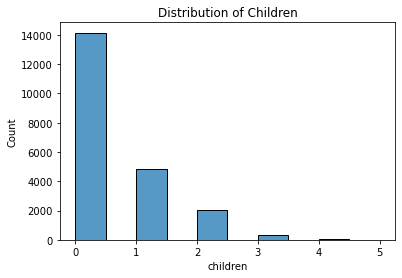

In [24]:
# let's check the distribution of 'children' column
sns.histplot(data_children_ok['children'], binwidth=0.5).set_title('Distribution of Children');

As we see, there are no outliers anymore, as we look at filtered data. Anyway the distribution is unsymmetrical, so  median (rather than mean) does a better job of capturing the *typical* number of children in our dataset.  

In [25]:
# let's check median values of children column itself and grouped by e.g.type of income and by family status
data_children_ok['children'].median()
data_children_ok.groupby('income_type')['children'].median()
data_children_ok.groupby('family_status')['children'].median()

0.0

income_type
business                       0.0
civil servant                  0.0
employee                       0.0
entrepreneur                   0.0
paternity / maternity leave    2.0
retiree                        0.0
student                        0.0
unemployed                     0.5
Name: children, dtype: float64

family_status
civil partnership    0.0
divorced             0.0
married              0.0
unmarried            0.0
widow / widower      0.0
Name: children, dtype: float64

From the data above we see that the median depends on income type. Meanwhile, as the share of odd values '20' and '-1' altogether is lower than 1% of the whole dataset, we won't go on figuring out median values by different categories and will just use the common one. Furthermore, it would look better to represent whole numbers of children in our final output (it's '0' for the common median), rather than having fractional ones (as it would be if we continue with calculating medians for number of children by different categories).

In [26]:
# fixing data by replacing odd numbers with median numbers
number = [20, -1] #values that we want to replace
for i in number:
    data.loc[data['children'] == i, 'children'] = data_children_ok['children'].median()

In [27]:
# Checking the 'children' column again to make sure it's all fixed
data['children'].value_counts()

0    14272
1     4818
2     2055
3      330
4       41
5        9
Name: children, dtype: int64

Now numbers in 'children' column are OK.

We've already investigated some minor issues in 'dob_years' column (zero values, while there should be none of them). But these mistakes in data don't play any crucial role to us and we won't go on fixing it (e.g. by filling mean values). 

In [28]:
# let's check the distribution of 'family_status' column
data['family_status'].value_counts()

married              12380
civil partnership     4177
unmarried             2813
divorced              1195
widow / widower        960
Name: family_status, dtype: int64

Everything looks fine with family statuses and their numbers. 

In [29]:
# let's check the distribution of 'gender' column
data['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Everything looks fine here as well.

In [30]:
# let's check the distribution of 'income_type' column
print(data['income_type'].value_counts())

employee                       11119
business                        5085
retiree                         3856
civil servant                   1459
unemployed                         2
entrepreneur                       2
student                            1
paternity / maternity leave        1
Name: income_type, dtype: int64


It's a bit strange - having such a low number of 'entrepreneur', 'student', 'unemployed' and 'paternity / maternity leave' categories. Meanwhile, further investigations of these data don't seem to be necessary.

In [31]:
# Let's check if we have any duplicates in our data.
print('Number of duplicates:', data.duplicated().sum(), 
      '\nShare of duplicates:', round(data.duplicated().sum()/len(data)*100, 2), '%')
print('-------')
print(data[data.duplicated()].head(10))

Number of duplicates: 71 
Share of duplicates: 0.33 %
-------
      children  days_employed  dob_years            education  education_id  \
2849         0            NaN         41  secondary education             1   
3290         0            NaN         58  secondary education             1   
4182         1            NaN         34    bachelor's degree             0   
4851         0            NaN         60  secondary education             1   
5557         0            NaN         58  secondary education             1   
6312         0            NaN         30  secondary education             1   
7808         0            NaN         57  secondary education             1   
7921         0            NaN         64    bachelor's degree             0   
7938         0            NaN         71  secondary education             1   
8583         0            NaN         58    bachelor's degree             0   

          family_status  family_status_id gender income_type  debt  

We can assume that there could be two reasons for having duplicates here:
- the same borrower (with the same set of features) several times applied for the same loan
- there are several borrowers with the same sets of features. This assumption is less likely to be the main, as work experience in days is quite unique data. 

In [32]:
# Addressing the duplicates
data = data.drop_duplicates().reset_index(drop=True)

In [33]:
# Last check whether we have any duplicates anymore
print(data.duplicated().sum())

0


In [34]:
# Check the size of the dataset that you now have after your first manipulations with it
len(data)

21454

We've fixed the duplicates and thus dataset became 0.33 % shorter.

# Working with missing values

As we revealed above, there are missing values in 'total_income' and 'days_employed' columns. Let's address them by replacing them with relevant *typical* values. Categorization of such characteristic as 'age' would make finding best *typical* values easier. 

### Restoring missing values in `total_income`

In [35]:
# Let's write a function that calculates the age category 

def age_group(age):
    
    """
    The function returns the age group according to the follofing rules:

    *'a  mistake' for age < 0
    'children' for age <= 18
    'young adults' for 19 <= age <= 34
    'adults' for 35 <= age <= 49
    'seniours' for 50 <= age <= 64
    'retired' for 65 <= age <= 119
    *'a God or a mistake' for age >= 120

    * - actually we don't need these categories for the current dataset, meanwhile, it could be useful in case we need to work with a different dataset in the future)
    """     
      
    if age < 0:
        return 'a mistake'   
    if age <= 18:
        return 'children'
    if 19 <= age <= 34:
        return 'young adults'
    if 35 <= age <= 49:
        return 'adults'
    if 50 <= age <= 64:
        return 'seniours'    
    if 65 <= age <= 119:
        return 'retired'
    if age >= 120:
        return 'a God or a mistake'    

In [36]:
# Test if the function works as supposed
print(age_group(-2))
print(age_group(16))
print(age_group(21))
print(age_group(38))
print(age_group(52))
print(age_group(89))
print(age_group(221))

a mistake
children
young adults
adults
seniours
retired
a God or a mistake


In [37]:
# Creating new column based on the function
data['age_group']=data['dob_years'].apply(age_group)

In [38]:
# Checking values in the new column
data['age_group'].value_counts()

adults          8229
seniours        6262
young adults    5967
retired          895
children         101
Name: age_group, dtype: int64

These 101 values in 'children' category seem to be zeros in this field, what we've already found out by now. We will address them later on if needed. 

Let's check 'total_income' distribution and descriptive statistics of several characteristics. This will help us find which one would be best for counting *typical* values for replacing missed ones.

In [39]:
pd.options.display.float_format = '{:20,.2f}'.format #Suppressing scientific notation in Pandas

#checking distributions and descriptive statistics of 'total_income' by different categories
data.groupby(['income_type'])['total_income'].agg(['count','median','mean','std','var'])
data.groupby(['age_group'])['total_income'].agg(['count','median','mean','std','var'])
data.groupby(['gender'])['total_income'].agg(['count','median','mean','std','var'])
data.groupby(['education'])['total_income'].agg(['count','median','mean','std','var'])

,count,median,mean,std,var
income_type,,,,,
business,4577,"27,577.27","32,386.79","20,876.98","435,848,098.82"
civil servant,1312,"24,071.67","27,343.73","15,500.60","240,268,666.99"
employee,10014,"22,815.10","25,820.84","14,611.60","213,498,923.76"
entrepreneur,1,"79,866.10","79,866.10",NaN,NaN
paternity / maternity leave,1,"8,612.66","8,612.66",NaN,NaN
retiree,3443,"18,962.32","21,940.39","12,839.51","164,853,081.81"
student,1,"15,712.26","15,712.26",NaN,NaN
unemployed,2,"21,014.36","21,014.36","16,152.07","260,889,514.80"


,count,median,mean,std,var
age_group,,,,,
adults,7429,"24,795.83","28,583.38","18,237.96","332,623,032.45"
children,91,"24,387.07","25,334.07","11,901.10","141,636,098.66"
retired,818,"18,471.39","21,542.65","13,145.45","172,802,847.79"
seniours,5615,"21,830.25","25,313.12","15,772.28","248,764,954.37"
young adults,5398,"23,399.82","26,669.11","14,737.66","217,198,477.63"


,count,median,mean,std,var
gender,,,,,
F,12752,"21,464.85","24,655.60","14,455.05","208,948,416.39"
M,6598,"26,834.30","30,907.14","19,145.39","366,545,781.86"
XNA,1,"32,624.83","32,624.83",NaN,NaN


,count,median,mean,std,var
education,,,,,
bachelor's degree,4716,"28,054.53","33,142.80","21,699.24","470,857,152.26"
graduate degree,6,"25,161.58","27,960.02","12,205.33","148,970,081.54"
primary education,261,"18,741.98","21,144.88","10,873.98","118,243,394.81"
secondary education,13693,"21,836.58","24,594.50","13,694.98","187,552,478.32"
some college,675,"25,618.46","29,045.44","15,633.69","244,412,336.81"


We see that income level depends a lot on all of the characteristics, but mostly on type of income.

In [40]:
# creating a table that only has data without missing values. This data will be used to restore the missing values.
data_without_na=data[data['total_income'].notna()]

#checking that it looks fine
data_without_na.sample(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
14044,1,-306.05,38,secondary education,1,married,0,M,employee,0,"20,483.68",building a real estate,adults
6105,0,"-5,716.73",39,secondary education,1,married,0,M,employee,0,"8,619.71",second-hand car purchase,adults
8550,1,-240.74,22,secondary education,1,married,0,M,employee,0,"19,792.90",construction of own property,young adults
1372,1,"-3,518.23",39,bachelor's degree,0,married,0,F,employee,0,"18,804.31",property,adults
5784,0,"-6,382.91",37,secondary education,1,married,0,M,employee,0,"12,908.32",real estate transactions,adults
3483,1,-94.01,35,secondary education,1,married,0,F,business,0,"23,875.88",building a real estate,adults
11754,0,"-1,675.33",45,secondary education,1,unmarried,4,F,business,0,"12,504.64",car purchase,adults
3306,3,"-7,138.42",36,secondary education,1,married,0,F,employee,0,"20,241.09",to buy a car,adults
3245,1,"339,255.48",55,secondary education,1,divorced,3,F,retiree,0,"19,441.99",property,seniours
3456,0,"-4,136.16",60,bachelor's degree,0,married,0,M,business,0,"41,757.26",housing,seniours


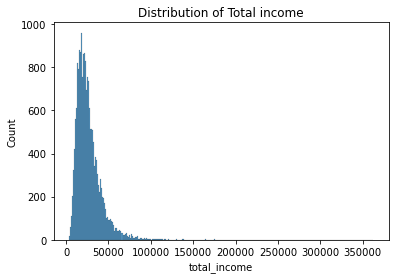

In [41]:
# let's check the distribution of 'total_income' column
sns.histplot(data_without_na['total_income']).set_title('Distribution of Total income');

As this distribution is fairly symmetrical and there are no outliers in the current dataset, we would rather use the mean to describe its center.

In [42]:
# Filling missed values using 'transform' function 
data['total_income'] = data['total_income'].fillna(data.groupby('income_type')['total_income'].transform('mean'))

In [43]:
# let's check missing values (it's also easy to perform it by use of the 'missing()' method from Sidetable library)
data.stb.missing(style=True)

,missing,total,percent
days_employed,"2,103","21,454",9.80%
children,0,"21,454",0.00%
dob_years,0,"21,454",0.00%
education,0,"21,454",0.00%
education_id,0,"21,454",0.00%
family_status,0,"21,454",0.00%
family_status_id,0,"21,454",0.00%
gender,0,"21,454",0.00%
income_type,0,"21,454",0.00%
debt,0,"21,454",0.00%


Everything looks fine here. In one table we see the absence of missing values in the 'total_income' column. The total number of values in this column matches the number of values in the other ones.

###  Restoring values in `days_employed`

Above we've already revealed that there are about 10% of missing values in 'days_employed' column. And 74% of negative values there, while none zeros. So **just some 16% of values in 'days_employed' column occur to be positive values. But even though, they represent unbelievably huge working experience and this part of data we also can't consider to be OK**.

In [44]:
# We noticed above that we've got just some 16% of correct data in 'days_employed' column. Just in case let's check it another way   
data_days_employed_positive=data[data['days_employed'] > 0] # data with just positive numbers in 'days_employed' column
len(data_days_employed_positive)/len(data)*100 # share in % of data with just positive numbers in 'days_employed' column

16.05761163419409

That's right what we expected to see.

Let's try to bring some extra value and investigate the data a bit. It won't directly help us to answer the Project questions but if we find something interesting we could provide some feedback that could lead to better quality of data in the future. 

*In real life, we would first ask the right person whether such investigations can be helpful or not really.*

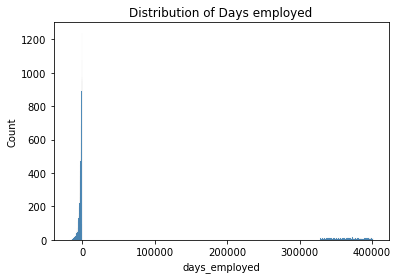

In [45]:
# let's check 'days_employed' column distribution as it is (just to visualize the numbers) 
sns.histplot(data['days_employed']).set_title('Distribution of Days employed');

We see that numbers here are either negative or enormously high.

Let's check 'days_employed' column with just positive numbers.

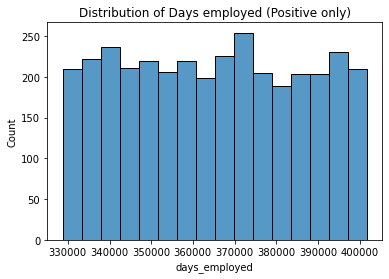

In [46]:
# checking 'days_employed' column distribution with just positive numbers
sns.histplot(data_days_employed_positive['days_employed']).set_title('Distribution of Days employed (Positive only)');

Let's check the 'days_employed' distribution and descriptive statistics of several characteristics. May be this will help us find any patterns. 

`Let's fix problematic data in days_employed column, we will do that by filling missing and negative values with *typical* ones. `

In [47]:
# checking distribution by different categories and descriptive statistics of 'days_employed' column with just positive numbers 
data_days_employed_positive.groupby(['income_type'])['days_employed'].agg(['count','mean','median','std','var'])
data_days_employed_positive.groupby(['age_group'])['days_employed'].agg(['count','mean','median','std','var'])
data_days_employed_positive.groupby(['gender'])['days_employed'].agg(['count','mean','median','std','var'])
data_days_employed_positive.groupby(['education'])['days_employed'].agg(['count','mean','median','std','var'])

,count,mean,median,std,var
income_type,,,,,
retiree,3443,"365,003.49","365,213.31","21,069.61","443,928,299.75"
unemployed,2,"366,413.65","366,413.65","40,855.48","1,669,170,125.01"


,count,mean,median,std,var
age_group,,,,,
adults,149,"367,050.84","366,904.81","22,041.15","485,812,481.42"
children,17,"362,537.52","366,067.78","24,439.83","597,305,093.63"
retired,701,"365,832.59","365,934.43","20,735.60","429,965,248.10"
seniours,2562,"364,702.40","364,717.08","21,057.26","443,408,333.86"
young adults,16,"360,620.94","358,702.12","25,720.86","661,562,734.89"


,count,mean,median,std,var
gender,,,,,
F,2807,"365,401.89","366,206.05","20,950.36","438,917,428.71"
M,638,"363,255.09","361,766.84","21,544.60","464,169,894.68"


,count,mean,median,std,var
education,,,,,
bachelor's degree,521,"365,234.13","366,159.82","21,346.48","455,672,142.39"
graduate degree,2,"356,930.52","356,930.52","27,358.95","748,512,370.61"
primary education,93,"362,288.37","360,264.99","20,741.10","430,193,027.32"
secondary education,2794,"364,997.62","365,005.40","21,041.60","442,749,018.95"
some college,35,"369,795.28","372,250.50","20,402.69","416,269,831.48"


Having just the 'retire' and 'unemployed' categories in filtered data (with just positive values) looks suspicious. Let's check the distribution of the 'income_type' column in the initial dataset and compare it with distribution in the filtered dataset.

In [48]:
# distribution of 'income_type' column in the initial dataset
data['income_type'].value_counts()

employee                       11084
business                        5078
retiree                         3829
civil servant                   1457
unemployed                         2
entrepreneur                       2
student                            1
paternity / maternity leave        1
Name: income_type, dtype: int64

In [49]:
# distribution of 'income_type' column in the filtered dataset
data_days_employed_positive['income_type'].value_counts()

retiree       3443
unemployed       2
Name: income_type, dtype: int64

It turns out that **in the initial data there are positive values in 'days_employed' column just in case of 'retiree' category in 'income_type' column** (and insignificant number in 'unemployed' category).

The number of working days is huge. It seems like there should be 'working hours' instead of 'working days'. Let's check how the numbers would look like if it was so.

In [50]:
#checking descriptive statistics of 'days_employed' column with just positive numbers and like hours switched into days 
data_days_employed_positive.groupby(['income_type'])['days_employed'].agg(['mean','median','std','var'])/24/365  # positive part of days_employed if there were numbers in hours, not days (displaying in years)

,mean,median,std,var
income_type,,,,
retiree,41.67,41.69,2.41,"50,676.75"
unemployed,41.83,41.83,4.66,"190,544.53"


Approximately 40 years of work experience before retirement looks quite realistic. If we could somehow verify our assumption *(e.g. by checking data sources, asking right person)*, we would definitely follow this approach and would change extremely huge numbers by dividing them by 24. But we can't make this verification.

Let's check the part of data with just negative values.

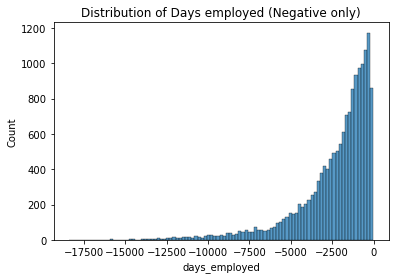

In [51]:
# checking 'days_employed' column distribution with just negative numbers
data_days_employed_negative=data[data['days_employed'] < 0] # data with just negative numbers in 'days_employed' column
len(data_days_employed_negative)/len(data)*100 # share in % of data with just negative numbers in 'days_employed' column
sns.histplot(data_days_employed_negative['days_employed']).set_title('Distribution of Days employed (Negative only)');

Let's assume that the minuses here a put here by mistake and check how distribution would look like in case of having pluses instead of minuses here. To make the output more explicit we would also display the numbers in years.

In [52]:
# checking distribution of the negative part of days_employed if it was positive by several categorites (displaying in years)
abs(data_days_employed_negative.groupby(['income_type','age_group'])['days_employed'].agg(['mean','median','std','var'])/365) 

mean  \
income_type                 age_group                           
business                    adults                       6.34   
                            children                     4.90   
                            retired                      9.02   
                            seniours                     7.99   
                            young adults                 3.77   
civil servant               adults                      10.34   
                            children                    16.11   
                            retired                     11.99   
                            seniours                    13.03   
                            young adults                 5.20   
employee                    adults                       6.89   
                            children                     5.22   
                            retired                     11.96   
                            seniours                     9.08   
                            young adults                 4.06   
entrepreneur                young adults                 1.43   
paternity / maternity leave adults                       9.03   
student                     young adults                 1.59   

                                                       median  \
income_type                 age_group                           
business                    adults                       4.98   
                            children                     2.94   
                            retired                      5.28   
                            seniours                     5.66   
                            young adults                 2.88   
civil servant               adults                       9.23   
                            children                    13.55   
                            retired                      9.15   
                            seniours                    10.46   
                            young adults                 4.62   
employee                    adults                       4.99   
                            children                     4.11   
                            retired                      8.88   
                            seniours                     6.21   
                            young adults                 3.24   
entrepreneur                young adults                 1.43   
paternity / maternity leave adults                       9.03   
student                     young adults                 1.59   

                                                          std  \
income_type                 age_group                           
business                    adults                       5.41   
                            children                     4.09   
                            retired                      8.63   
                            seniours                     7.91   
                            young adults                 3.02   
civil servant               adults                       7.04   
                            children                     8.29   
                            retired                      9.98   
                            seniours                    10.20   
                            young adults                 3.49   
employee                    adults                       6.14   
                            children                     5.19   
                            retired                     10.78   
                            seniours                     8.80   
                            young adults                 3.22   
entrepreneur                young adults                  NaN   
paternity / maternity leave adults                        NaN   
student                     young adults                  NaN   

                                                          var  
income_type                 age_group                          
business                  

These numbers seem to be quite realistic, but lower than they are expected to be (~10 years mean of work experience for seniors  looks not enough). We again can't make any verification of these data to check our assumption.

Finally, we have two assumptions about the reasons for wrong data in 'days_employed' column, but we can't verify them. Anyway, it seems better to fix the mistakes in data using our assumptions rather than leave these confusing numbers.

So, we will replace huge positive numbers with the same but divided by 24 (like it were hours, not days were must be put initially), and replace the negative numbers in this column with the same but positive ones.

In [53]:
# fixing data in 'days_employed' column, 'where()' method from Numpy library will by handy here
data['days_employed'] = np.where(data['days_employed'] > 25550, data['days_employed']/24, data['days_employed']) # replacing huge positive numbers with the same but divided by 24
data['days_employed'] = np.where(data['days_employed'] < 0, abs(data['days_employed']), data['days_employed']) # replacing negative numbers with the same but positive ones

We saw above that 'days_employed' column values defer a lot by 'income type' characteristic.  So we will use its median to replace missing ones. We use the median (not mean) - as data distribution is not symmetric. 

In [54]:
# Filling missed values using 'transform' function 
data['days_employed'] = data['days_employed'].fillna(data.groupby('income_type')['days_employed'].transform('median'))

In [55]:
# let's check the slice of data
data.sample(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
18333,0,"1,574.20",67,secondary education,1,civil partnership,1,F,employee,0,"25,820.84",to have a wedding,retired
12546,0,"1,673.38",59,secondary education,1,married,0,M,employee,0,"21,523.17",to buy a car,seniours
12466,0,"7,962.74",52,secondary education,1,married,0,F,employee,0,"21,166.70",purchase of my own house,seniours
7610,0,"2,371.01",29,secondary education,1,married,0,F,civil servant,1,"18,031.99",getting an education,young adults
18689,0,"1,547.38",62,some college,2,civil partnership,1,M,business,0,"32,386.79",to have a wedding,seniours
72,1,"2,689.37",32,bachelor's degree,0,married,0,M,civil servant,0,"27,343.73",transactions with commercial real estate,young adults
5550,0,211.03,30,bachelor's degree,0,unmarried,4,F,employee,0,"25,223.84",to own a car,young adults
16189,1,661.14,43,secondary education,1,married,0,F,business,0,"31,073.15",going to university,adults
18440,0,572.55,49,secondary education,1,married,0,F,employee,1,"12,410.75",transactions with commercial real estate,adults
11848,0,"2,840.67",45,secondary education,1,married,0,M,business,0,"42,180.02",buy commercial real estate,adults


In [56]:
# let's check missing values 
data.stb.missing(style=True)

,missing,total,percent
children,0,"21,454",0.00%
days_employed,0,"21,454",0.00%
dob_years,0,"21,454",0.00%
education,0,"21,454",0.00%
education_id,0,"21,454",0.00%
family_status,0,"21,454",0.00%
family_status_id,0,"21,454",0.00%
gender,0,"21,454",0.00%
income_type,0,"21,454",0.00%
debt,0,"21,454",0.00%


The result looks fine. We don't see missing values in the 'total_income' column anymore. The total number of values in this column matches the number of values in the other ones. 

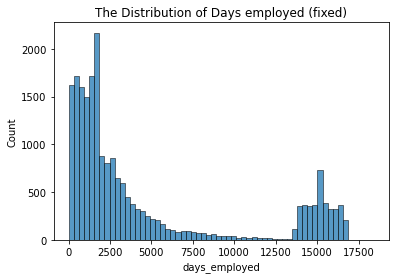

In [57]:
# let's take a look at the distribution of 'days_employed' column after fixing the data in it
sns.histplot(data['days_employed']).set_title('The Distribution of Days employed (fixed)');

As we mentioned above, several columns have the real number data type while it's better to have integers. Now when we've got rid of missing values we can turn floats into integers without facing errors.

In [58]:
# Replacing float with integer data type 
for characteristic in data: # going through all column names
    if data[characteristic].dtype == 'float64': # if a column data type is 'float64'
        data[characteristic] = data[characteristic].astype('int64') # turn the data type into 'int64'

In [59]:
# let's check the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21454 non-null  int64 
 1   days_employed     21454 non-null  int64 
 2   dob_years         21454 non-null  int64 
 3   education         21454 non-null  object
 4   education_id      21454 non-null  int64 
 5   family_status     21454 non-null  object
 6   family_status_id  21454 non-null  int64 
 7   gender            21454 non-null  object
 8   income_type       21454 non-null  object
 9   debt              21454 non-null  int64 
 10  total_income      21454 non-null  int64 
 11  purpose           21454 non-null  object
 12  age_group         21454 non-null  object
dtypes: int64(7), object(6)
memory usage: 2.1+ MB


All is fine now. We see 7 integer columns and 6 object data type columns. 

## Categorization of data

To answer one of the Project questions (how do different loan purposes affect on-time loan repayment?) it's needed to categorize the 'purpose' column. As we see, there are many purposes with the same meaning but written in other words.

Defining categories for 'total_income' column is essential for answering another question of the Project (is there a connection between income level and repaying a loan on time?).

In [60]:
# let's look at the 'purpose' column sample
data['purpose'].sample(10)

9674             purchase of my own house
17777            purchase of my own house
12093                  to become educated
2933             buying a second-hand car
4587                     having a wedding
16795    transactions with my real estate
1814                    to have a wedding
12303                                 car
16268            getting higher education
8331                      buy real estate
Name: purpose, dtype: object

In [61]:
# checking the unique values
data['purpose'].unique()

array(['purchase of the house', 'car purchase', 'supplementary education',
       'to have a wedding', 'housing transactions', 'education',
       'having a wedding', 'purchase of the house for my family',
       'buy real estate', 'buy commercial real estate',
       'buy residential real estate', 'construction of own property',
       'property', 'building a property', 'buying a second-hand car',
       'buying my own car', 'transactions with commercial real estate',
       'building a real estate', 'housing',
       'transactions with my real estate', 'cars', 'to become educated',
       'second-hand car purchase', 'getting an education', 'car',
       'wedding ceremony', 'to get a supplementary education',
       'purchase of my own house', 'real estate transactions',
       'getting higher education', 'to own a car', 'purchase of a car',
       'profile education', 'university education',
       'buying property for renting out', 'to buy a car',
       'housing renovation', 'going

We can reveal such categories: real estate, car, education, wedding

In [62]:
# Let's write a function to categorize the data based on common topics
purpose_lemmas_list = []

for purpose in data['purpose'].unique():
    words = nltk.word_tokenize(purpose) #spliting words using tokenezation
    lemmas = [wordnet_lemma.lemmatize(w, pos = 'n') for w in words] #lemmatizing words (getting innitial form)
    lemmas=[l.lower() for l in lemmas] # making all letters lowercase (just in case there uppercases as well, it's not needed righ in this dataset but can be useful in future)
    
    for i in lemmas:
        purpose_lemmas_list.append(i)

In [63]:
# let's see what we have in the list of lemmas (canonical forms of words) 
purpose_lemmas_list

['purchase',
 'of',
 'the',
 'house',
 'car',
 'purchase',
 'supplementary',
 'education',
 'to',
 'have',
 'a',
 'wedding',
 'housing',
 'transaction',
 'education',
 'having',
 'a',
 'wedding',
 'purchase',
 'of',
 'the',
 'house',
 'for',
 'my',
 'family',
 'buy',
 'real',
 'estate',
 'buy',
 'commercial',
 'real',
 'estate',
 'buy',
 'residential',
 'real',
 'estate',
 'construction',
 'of',
 'own',
 'property',
 'property',
 'building',
 'a',
 'property',
 'buying',
 'a',
 'second-hand',
 'car',
 'buying',
 'my',
 'own',
 'car',
 'transaction',
 'with',
 'commercial',
 'real',
 'estate',
 'building',
 'a',
 'real',
 'estate',
 'housing',
 'transaction',
 'with',
 'my',
 'real',
 'estate',
 'car',
 'to',
 'become',
 'educated',
 'second-hand',
 'car',
 'purchase',
 'getting',
 'an',
 'education',
 'car',
 'wedding',
 'ceremony',
 'to',
 'get',
 'a',
 'supplementary',
 'education',
 'purchase',
 'of',
 'my',
 'own',
 'house',
 'real',
 'estate',
 'transaction',
 'getting',
 'higher'

In [64]:
# sorted list
sorted(pd.Series(purpose_lemmas_list).unique())

['a',
 'an',
 'become',
 'building',
 'buy',
 'buying',
 'car',
 'ceremony',
 'commercial',
 'construction',
 'educated',
 'education',
 'estate',
 'family',
 'for',
 'get',
 'getting',
 'going',
 'have',
 'having',
 'higher',
 'house',
 'housing',
 'my',
 'of',
 'out',
 'own',
 'profile',
 'property',
 'purchase',
 'real',
 'renovation',
 'renting',
 'residential',
 'second-hand',
 'supplementary',
 'the',
 'to',
 'transaction',
 'university',
 'wedding',
 'with']

In [65]:
# counting number of entries of the words in the list
pd.Series(purpose_lemmas_list).value_counts()

a                9
car              9
estate           7
education        7
real             7
to               6
purchase         6
of               5
property         4
transaction      4
own              4
my               4
buy              4
house            3
housing          3
buying           3
wedding          3
building         2
commercial       2
university       2
for              2
with             2
getting          2
supplementary    2
the              2
second-hand      2
profile          1
higher           1
renting          1
ceremony         1
out              1
renovation       1
get              1
residential      1
an               1
educated         1
become           1
construction     1
family           1
having           1
have             1
going            1
dtype: int64

In [66]:
# creating lists of keywords for defined categories
real_estate_category = ['estate', 'real', 'property', 'house', 'housing', 'construction', 'renovation', 'residential']
car_category = ['car']
education_category = ['education', 'university']
wedding_category = ['wedding', 'educated']

In [67]:
# writing function giving lemma as output
def lemmatization_func(line):
    words = nltk.word_tokenize(line) #spliting words using tokenezation
    lemmas = [wordnet_lemma.lemmatize(w, pos = 'n') for w in words]  #lemmatizing words (getting innitial form)
    lemmas=[l.lower() for l in lemmas] # making all letters lowercase (just in case there uppercases as well, it's not needed righ in this dataset but can be useful in future)
    return lemmas

In [68]:
# checking how the function works
example=data.loc[0]['purpose']
example #sample purpose

lemmatization_func(example) #lemmatized sample
any(word in lemmatization_func(example) for word in real_estate_category) #checking whether this sample meets criteria of 'real_estate_category'
any(word in lemmatization_func(example) for word in wedding_category) #checking whether this sample meets criteria of 'wedding_category'

'purchase of the house'

['purchase', 'of', 'the', 'house']

True

False

In [69]:
any(word in lemmatization_func(example) for word in real_estate_category)

True

In [70]:
any(word in lemmatization_func(example) for word in wedding_category)

False

Everything looks fine here, as expected. 

In [71]:
#function with only one possible category

def lemmatization_func_category(line):   

    """
    The function returns the category group according to the following rules:

    'real_estate' for matching any word in 'purpose' with any word in the list: 'estate', 'real', 'property', 'house', 'housing', 'construction', 'renovation', 'residential'.
    'car' for matching any word in 'purpose' with any word in the list: 'car'
    'education' for matching any word in 'purpose' with any word in the list: 'education', 'university'
    'wedding' for matching any word in 'purpose' with any word in the list: 'wedding', 'educated'
    'other' for all other cases.
    """  
    words = nltk.word_tokenize(line) #spliting words using tokenezation
    lemmas = [wordnet_lemma.lemmatize(w, pos = 'n') for w in words]  #lemmatizing words (getting innitial form)
    lemmas=[l.lower() for l in lemmas] # making all letters lowercase (just in case there uppercases as well, it's not needed righ in this dataset but can be useful in future)
    
    if any(word in lemmas for word in real_estate_category):
        return 'real_estate'
    elif  any(word in lemmas for word in car_category):
        return 'car'
    elif  any(word in lemmas for word in education_category):
        return 'education'
    elif  any(word in lemmas for word in wedding_category):
        return 'wedding'
    else:        
        return 'other'

In [72]:
# checking the function
lemmatization_func_category(example)

'real_estate'

In [73]:
# creating 'purpose_category' column by use of this function
data['purpose_category'] = data['purpose'].apply(lemmatization_func_category)

In [74]:
# looking at the dataset with new column
data.sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group,purpose_category
13778,0,9268,51,bachelor's degree,0,divorced,3,F,employee,0,27115,property,seniours,real_estate
151,0,896,37,bachelor's degree,0,civil partnership,1,F,business,0,74094,to have a wedding,adults,wedding
11442,0,4338,37,secondary education,1,civil partnership,1,M,employee,0,31734,supplementary education,adults,education
10774,0,1828,46,secondary education,1,civil partnership,1,F,employee,1,23356,to have a wedding,adults,wedding
19594,0,15780,63,bachelor's degree,0,civil partnership,1,F,retiree,0,27254,having a wedding,seniours,wedding


In [75]:
# Looking at each categories values to see the distribution
data['purpose_category'].value_counts()

real_estate    10811
car             4306
education       3605
wedding         2732
Name: purpose_category, dtype: int64

We are done by now with the categorization of the 'purpose' column. Next, let's define categories for 'total_income' column as well.

In [76]:
# Looking through all the numerical data in 'total_income' column 
data['total_income']

0        40620
1        17932
2        23341
3        42820
4        25378
         ...  
21449    35966
21450    24959
21451    14347
21452    39054
21453    13127
Name: total_income, Length: 21454, dtype: int64

In [77]:
# Getting summary statistics for the column
data['total_income'].describe()

count              21,454.00
mean               26,788.61
std                15,689.70
min                 3,306.00
25%                17,219.50
50%                24,301.50
75%                32,386.00
max               362,496.00
Name: total_income, dtype: float64

In [78]:
# Creating function for categorizing into different numerical groups based on ranges

def income_category(income):
    
    """
    The function returns the age group according to the following rules:

    *'very low income' for income representing the lowest 20% of the dataset
    'low income' for income between 20% and 40% from the bottom of the dataset
    'medium income' for income between 40% and 60% from the bottom of the dataset
    'high income' for income between 60% and 80% from the bottom of the dataset
    'very high income' for the top 20% of values in the income column

    * - actually we don't need this category for the current dataset, meanwhile, it could be useful in case we need to work with a different dataset in the future)
    """
    
    if income < 0:
        return 'a mistake'   
    if income <= data['total_income'].quantile(0.2):
        return 'very low income'
    if data['total_income'].quantile(0.2) < income <= data['total_income'].quantile(0.4):
        return 'low income'
    if data['total_income'].quantile(0.4) < income <= data['total_income'].quantile(0.6):
        return 'medium income'
    if data['total_income'].quantile(0.6) < income <= data['total_income'].quantile(0.8):
        return 'high income'    
    if income >= data['total_income'].quantile(0.8):
        return 'very high income'

In [79]:
# checking the function
income_category(-5)
income_category(10000)
income_category(28000)

'a mistake'

'very low income'

'high income'

The function works as supposed.

In [80]:
# creating 'income_category' column by use of the function
data['income_category']=data['total_income'].apply(income_category)

In [81]:
# looking at the dataset with new column
data.sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group,purpose_category,income_category
20759,0,10158,49,secondary education,1,married,0,F,employee,0,16570,purchase of the house for my family,adults,real_estate,low income
16477,1,247,38,secondary education,1,married,0,F,business,0,10216,purchase of the house,adults,real_estate,very low income
3291,0,4282,61,bachelor's degree,0,married,0,M,business,0,60171,purchase of the house,seniours,real_estate,very high income
4005,1,360,25,some college,2,civil partnership,1,F,employee,0,10848,building a property,young adults,real_estate,very low income
12254,0,5113,55,primary education,3,married,0,F,employee,0,6316,buying property for renting out,seniours,real_estate,very low income


In [82]:
# Looking at each categories values to see the distribution
data['purpose_category'].value_counts()

real_estate    10811
car             4306
education       3605
wedding         2732
Name: purpose_category, dtype: int64

Everything looks fine here. With such categories answering the Project questions would be much easier.

## Checking the Hypotheses


Let's first define what a default rate is.

Default rate = (number of defaulted loans) / (total number of loans) * 100 

Let's recollect that '1' in the 'debt' column stands for having debt, while '0' stands for lack of debt.


**Is there a correlation between having children and paying back on time?**

In [83]:
# Calculating default-rate based on the number of children
pd.Series(data.groupby('children')['debt'].sum() # sum of 'debt' column grouped by children (number of defaulted loans)
          /data.groupby('children')['debt'].count()*100).sort_values(ascending = False)  # counting all cases of loans grouped by children (totall number of loans)

children
4                   9.76
2                   9.45
1                   9.23
3                   8.18
0                   7.54
5                   0.00
Name: debt, dtype: float64

It seems that using mean values would give us the same result, let's check it.

In [84]:
# Calculating default-rate based on the number of children using means
pd.Series(data.groupby('children')['debt'].mean()*100).sort_values()


children
5                   0.00
0                   7.54
3                   8.18
1                   9.23
2                   9.45
4                   9.76
Name: debt, dtype: float64

As expected, mean as well represents default-rate here. So we will continue to use it for calculating default-rates.

In [85]:
# let's see the numbers of defaulted loans and total numbers of loans grouped by the 'children' column in the one table
data.groupby('children')['debt'].agg(['sum','count'])

,sum,count
children,,
0,1072,14214
1,444,4808
2,194,2052
3,27,330
4,4,41
5,0,9


In [86]:
# let's see the distribution of number of children in %
data['children'].value_counts()/len(data)*100

0                  66.25
1                  22.41
2                   9.56
3                   1.54
4                   0.19
5                   0.04
Name: children, dtype: float64

**Conclusion**
- yes, **there is a correlation between having children and paying back on time**.
- at first sight, borrowers with 5 children are the most reliable (0 default cases for this group). But we shouldn't trust this assumption a lot, as this group represents less than 0,1% of all cases.
- borrowers with 4 and 3 children also seem to be not the most reliable categories. They represent just 0,2% and 1,5% of all cases respectively. It's not worth trusting a lot to the outcomes of these groups.
- **borrowers without children are the ones who most likely will pay the debt on time.** Theirs default-rate is the lowest (from those for whom we have enough data for verification) - 7,5%. We can be sure of this conclusion as this group of borrowers represents over 66% of all cases.
- borrowers with 1 child are less likely to pay the debt (compare to those who don't have children). Their default-rate is 9,2%.
- borrowers with 2 children are a bit less likely to pay the debt (compare to those who have 1 child). Their default-rate is 9,5%.
- we can't make any conclusions for cases with more than 5 children (there are no such in our initial data set).
- we can make **an assumption that higher number of children leads to higher default rate**. We have not enough data (for cases with borrowers having over 2 children) to be very sure in this assumption.

**Is there a correlation between family status and paying back on time?**

Let's try to answer this question by creating a pivot table, seems this solution could be shorter.

In [87]:
# creating pivot table for 'family_status' and paying back on time
pivot_family_status = data.pivot_table(index = 'family_status', values = 'debt', aggfunc = ['sum','count'])
pivot_family_status['share_of_cases'] = pivot_family_status['count']/len(data) # creating a column representing share of cases
pivot_family_status['default_rate'] = pivot_family_status['sum']/pivot_family_status['count']*100 # creating a column representing default rate
pivot_family_status.sort_values(by = 'default_rate') # pivot_table sorted by default rate

,sum,count,share_of_cases,default_rate
,debt,debt,,
family_status,,,,
widow / widower,63,959,0.04,6.57
divorced,85,1195,0.06,7.11
married,931,12339,0.58,7.55
civil partnership,388,4151,0.19,9.35
unmarried,274,2810,0.13,9.75


Now we see all the needed data just in the one pivot table! 

**Conclusion**
- yes, **there is a correlation between family status and paying back on time**.
- **widowers are the ones who most likely will pay the debt on time.** Theirs default-rate is the lowest - 6,6%
- **unmarried borrowers are the ones who most likely (compared with the other categories) will not pay the debt on time.** Theirs default-rate is the highest - 9,8%.
- default rates of all family categories seem to be worth trusting, as each of them represents a significant share of data.

**Is there a correlation between income level and paying back on time?**

When answering this question, we will use 'income_category' values instead of 'income_level' values. Thus the output would be more lucid.

In [88]:
# creating pivot table for 'income_category' and paying back on time
pivot_income_category = data.pivot_table(index = 'income_category', values = 'debt', aggfunc = ['sum','count'])
pivot_income_category['share_of_cases'] = pivot_income_category['count']/len(data) # creating a column representing share of cases
pivot_income_category['default_rate'] = pivot_income_category['sum']/pivot_income_category['count']*100 # creating a column representing default rate
pivot_income_category.sort_values(by = 'default_rate') # pivot_table sorted by default rate

,sum,count,share_of_cases,default_rate
,debt,debt,,
income_category,,,,
very high income,300,4291,0.20,6.99
very low income,344,4291,0.20,8.02
low income,355,4291,0.20,8.27
high income,358,4290,0.20,8.34
medium income,384,4291,0.20,8.95


**Conclusion**
- yes, **there is a correlation between income level and paying back on time**.
- **borrowers with very high incomes are the ones who most likely will pay the debt on time.** Theirs default-rate is the lowest - 7,0%.
- **borrowers with medium income are the ones who most likely (compared with the other categories) will not pay the debt on time.** Theirs default-rate is the highest - 9,0%.
- **the output is not very intuitively clear**. Most reliable borrowers from the highest income group seem to be predictable. But borrowers with very low income being the second most reliable category seem to be strange, as well as people with medium income in the last place. We can assume that e.g. people with very low income are trying harder to pay debts on time than people from just the low-income category. As they better care about their credit track (knowing that maybe they won't have a second chance). But it's not obvious how we can validate such assumptions, so we take the output for granted. 

**How does credit purpose affect the default rate?**

In [89]:
# creating pivot table for credit purpose and paying back on time
pivot_purpose_category = data.pivot_table(index = 'purpose_category', values = 'debt', aggfunc = ['sum','count'])
pivot_purpose_category['share_of_cases'] = pivot_purpose_category['count']/len(data) # creating a column representing share of cases
pivot_purpose_category['default_rate'] = pivot_purpose_category['sum']/pivot_purpose_category['count']*100 # creating a column representing default rate
pivot_purpose_category.sort_values(by = 'default_rate') # pivot_table sorted by default rate

,sum,count,share_of_cases,default_rate
,debt,debt,,
purpose_category,,,,
real_estate,782,10811,0.50,7.23
wedding,225,2732,0.13,8.24
education,331,3605,0.17,9.18
car,403,4306,0.20,9.36


**Conclusion**
- yes, **there is a correlation between credit purpose and paying back on time**.
- **borrowers taking loans for real estate are the ones who most likely will pay the debt on time.** Theirs default-rate is the lowest - 7,2%.
- **borrowers taking loans for cars are the ones who most likely (compared with the other categories) will not pay the debt on time.** Theirs default-rate is the highest - 9,4%.
- default rates of all purpose categories seem to be worth trusting, as each of them represents a significant share of data.

\*We can take some initiative and create a complex pivot table, showing which combinations of categories we have been investigating represent the most reliable borrowers and otherwise. 

\* *in real life we would first ask the right person whether such an extra insight would be of help.*

In [90]:
# creating pivot table on investigating categories of borrowers
data_total_pivot = data.pivot_table(index=['children', 'family_status', 'purpose_category','income_category'], values='debt', aggfunc = ['sum','count']).reset_index()

# creating a 'default_rate' column 
data_total_pivot['default_rate'] = data_total_pivot['sum']/data_total_pivot['count']*100

# creating a 'representativity' column, showing the share of combinations of categories from all cases. 
data_total_pivot['representativity'] = data_total_pivot['count'] / len(data)*100

In [91]:
# the most reliable combinations of categories, we display only cases with representativity over 1%
data_total_pivot[data_total_pivot['representativity'] > 1].sort_values(by='default_rate').head(10)

,children,family_status,purpose_category,income_category,sum,count,default_rate,representativity
,,,,,debt,debt,,
49,0,married,real_estate,low income,41,807,5.08,3.76
51,0,married,real_estate,very high income,49,854,5.74,3.98
69,0,unmarried,real_estate,low income,16,276,5.80,1.29
72,0,unmarried,real_estate,very low income,15,249,6.02,1.16
48,0,married,real_estate,high income,52,851,6.11,3.97
147,1,married,real_estate,low income,20,325,6.15,1.51
148,1,married,real_estate,medium income,22,348,6.32,1.62
18,0,civil partnership,wedding,very high income,19,299,6.35,1.39
146,1,married,real_estate,high income,24,372,6.45,1.73


In [92]:
# the less reliable combinations of categories, we display only cases with representativity over 1%
data_total_pivot[data_total_pivot['representativity'] > 1].sort_values(by='default_rate').tail(10)

,children,family_status,purpose_category,income_category,sum,count,default_rate,representativity
,,,,,debt,debt,,
70,0,unmarried,real_estate,medium income,19,248,7.66,1.16
71,0,unmarried,real_estate,very high income,20,257,7.78,1.20
47,0,married,education,very low income,24,299,8.03,1.39
50,0,married,real_estate,medium income,70,855,8.19,3.99
38,0,married,car,high income,29,345,8.41,1.61
16,0,civil partnership,wedding,low income,29,338,8.58,1.58
68,0,unmarried,real_estate,high income,26,267,9.74,1.24
45,0,married,education,medium income,28,283,9.89,1.32
150,1,married,real_estate,very low income,30,300,10.00,1.40


Information in the last two tables helps to get an idea of the best and the worst combinations of categories we have been investigating. This pivot table would be more credible on larger datasets (with possibly less outliers on combinations of categories).

# General Conclusion 


### Data Cleaning Process:

1. **Identification of Missing Values:**
   - 'days_employed' and 'total_income' columns contained significant missing values, impacting 10% of the dataset.
   - Investigations showed the missing values in both columns were interconnected, not random.

2. **Exploring Missing Values:**
   - Assumption of missing values due to lack of working experience debunked, as various income types were present.
   - No obvious patterns found between missing values and income type/family status.

3. **Filling Missing Values:**
   - Utilized `fillna()` method with `transform()` function to fill missing values, opting for a shorter and more explicit approach.

4. **Identification of Other Missing Values:**
   - Discovered unexpected zeros in 'dob_years' column and corrected them.
   - Detected and removed 71 duplicates, representing 0.33% of the data.

5. **Handling Duplicates:**
   - Duplicates could be attributed to multiple loan applications or borrowers with identical characteristics.
   - Fixed duplicates in 'education' column by converting all entries to lowercase.

6. **Standardizing 'Purpose' Column:**
   - Categorized 'purpose' column data using tokenization and lemmatization methods from NLTK Python package.

7. **Data Type Conversion:**
   - Converted several columns to integer type using `astype()` method.

8. **Addressing Artifacts:**
   - Addressed artifacts like negative values in 'children' column and unrealistic values in 'days_employed' column.

9. **Noting Data Anomalies:**
   - Identified anomalies indicating potential issues with data logging/gathering.

### Analysis:

- **Correlation Analysis:**
  - Established correlation between parameters (children, marital status, income level, loan purposes) and loan repayment.
  - Calculated default rates using the formula: Default rate = (number of defaulted loans) / (total number of loans) * 100.


- **Outcome:**
  - Borrowers without children, high-income earners, widowers, and those seeking real estate loans showed the lowest default rates.
  - However, combining these favorable borrower categories did not result in the lowest default rate, as demonstrated by an additional pivot table analysis.
